In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

import atmos

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
def chuck_data_helper(save_name, column_names):
    try:
        df = pd.read_parquet(save_name)
    except:
        df = pd.read_clipboard(names=column_names)
        df.to_parquet(save_name)
    return df

In [38]:
activity_df = chuck_data_helper(save_name='activity_data'
                                , column_names=['time','distance','power','cadence','heartrate'
                                                ,'speed','altitude','lat','long','slope'])
activity_df['speed'] = activity_df['speed']*1000/60/60
activity_df['acceleration'] = (activity_df['speed']-activity_df['speed'].shift(1))
activity_df['time'] = activity_df['time'].apply(lambda x: int(x.replace(',','')))

In [39]:
weather_df = chuck_data_helper(save_name='weather_data'
                               , column_names=['Time','distance','TEMPERATURE','HUMIDITY'
                                               ,'WINDSPEED','WINDDIRECTION','PRESSURE'])

In [40]:
weather_df['WINDSPEED']/3.6

0    0.571667
1    0.571667
2    0.571667
3    0.571667
4    0.571667
5    0.571667
Name: WINDSPEED, dtype: float64

In [41]:
intervals = [
#    (15*60+15,16*60+47)
    (2*60+ 30, 3*60+ 24)
    ,(8*60+ 9, 8*60+ 51)
    ,(13*60+ 49, 14*60+ 29)
    ,(24*60+ 18, 25*60+ 0)
    ,(29*60+ 25, 30*60+ 7)
]

In [42]:
closest_weather_reading_idx = abs((weather_df['Time'] - intervals[0][0]) + (weather_df['Time'] - intervals[0][1])).argmin()
closest_weather_reading = weather_df.loc[closest_weather_reading_idx]
rho_inputs = {'p':closest_weather_reading['PRESSURE']
             ,'T':273+closest_weather_reading['TEMPERATURE']
             ,'RH':closest_weather_reading['HUMIDITY']/100}

In [43]:
rho = atmos.calculate('rho', **rho_inputs)

In [44]:
Crr = .0055
CdA = .3
athlete_mass = 84
bike_mass = 7.60
gear_mass = 1.50
system_mass = athlete_mass + bike_mass + gear_mass
gravity = 9.81

In [55]:
def solve_power(Crr, m, g, v, s, a, CdA, rho, v_air):
    Crr_comp = Crr * (m * g * v)
    slope_comp = s * (m * g * v)
    accel_comp = m * a * v
    drag_comp = 0.5 * (CdA * rho * v_air**2 * v)
    w = Crr_comp + slope_comp + accel_comp + drag_comp
    return w

def solve_power_nowind(Crr, m, g, v, a, CdA, rho, w):
    s = w / (m*g*v) - Crr - a/g - (rho*CdA*v**2)/(2*m*g)
    return s

## Test function & dataflow

In [56]:
def interval_extract(data, interval_start, interval_end):
    return data[(data['time'] >= interval_start) & (data['time'] <= interval_end)]

In [57]:
print({'rho':rho
       ,'system_mass':system_mass
       })

{'rho': 1.2032140833230747, 'system_mass': 93.1}


In [61]:
solve_power(Crr=.0055,
            CdA=0.25,
            m=system_mass,
            g=gravity,
            v=np.ones(50)*11.1,
            s=np.zeros(50),
            a=np.zeros(50),
            rho=rho,
            v_air=np.ones(50)*11.1)

array([261.45174655, 261.45174655, 261.45174655, 261.45174655,
       261.45174655, 261.45174655, 261.45174655, 261.45174655,
       261.45174655, 261.45174655, 261.45174655, 261.45174655,
       261.45174655, 261.45174655, 261.45174655, 261.45174655,
       261.45174655, 261.45174655, 261.45174655, 261.45174655,
       261.45174655, 261.45174655, 261.45174655, 261.45174655,
       261.45174655, 261.45174655, 261.45174655, 261.45174655,
       261.45174655, 261.45174655, 261.45174655, 261.45174655,
       261.45174655, 261.45174655, 261.45174655, 261.45174655,
       261.45174655, 261.45174655, 261.45174655, 261.45174655,
       261.45174655, 261.45174655, 261.45174655, 261.45174655,
       261.45174655, 261.45174655, 261.45174655, 261.45174655,
       261.45174655, 261.45174655])

In [53]:
interval_num = 4

interval_df = interval_extract(activity_df, interval_start=intervals[interval_num][0], interval_end=intervals[interval_num][1])
results = {}
for CdA in range(18,32):
    CdA = CdA/100
    # results[CdA] = solve_power_nowind(Crr=Crr, CdA=CdA, m=system_mass, g=gravity, v=interval_df['speed'], a=interval_df['acceleration'], rho=rho, w=interval_df['power']).cumsum()
    results[CdA] = solve_power(Crr=Crr,
                               CdA=CdA,
                               m=system_mass,
                               g=gravity,
                               v=interval_df['speed'],
                               s=activity_df['slope'],
                               a=interval_df['acceleration'],
                               rho=rho,
                               v_air=interval_df['speed']
    )
# results['actual'] = interval_df['slope']

<AxesSubplot:>

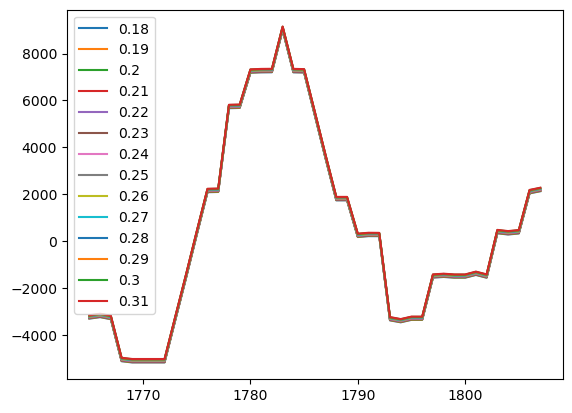

In [54]:
pd.DataFrame(results).plot()

In [ ]:
interval_df = interval_extract(activity_df, interval_start=intervals[0][0], interval_end=intervals[0][1])

def optimize_CdA(params):    
    losses = []

    pred_slope_change = solve_power_nowind(Crr=params[1], CdA=params[0], m=system_mass, g=gravity, v=interval_df['speed'], a=interval_df['acceleration'], rho=rho, w=interval_df['power'])
    
    losses = abs(activity_df['altitude'] - pred_slope_change)
    MAE = np.mean(losses)
    print(params[0], params[1], MAE)
    return MAE
                # CdA  Crr
initial_guess  = [.3, .005]
modeled_CdA = optimize.minimize(optimize_CdA
                                ,x0=initial_guess
                                        # CdA          Crr
                                ,bounds=[(.15,0.40),(.004,0.007)]
                                ,method='Nelder-Mead'
                                ,tol=1e-4
                                )
print(modeled_CdA)
for val in modeled_CdA['x']:
    print(val)

0.3 0.005 8.680553653282097
0.315 0.005 8.68132563566065
0.3 0.00525 8.680803653282098
0.285 0.00525 8.680031670903546
0.2699999999999999 0.005375 8.679384688524992
0.26999999999999985 0.0051249999999999985 8.679134688524993
0.2549999999999998 0.0050624999999999976 8.678300206146442
0.2249999999999997 0.005437499999999997 8.677131241389338
0.18749999999999956 0.005656249999999996 8.675420035442956
0.17249999999999943 0.005343749999999994 8.674335553064406
0.15 0.005328124999999993 8.673161954496578
0.15 0.005921874999999991 8.673755704496582
0.15 0.005593749999999988 8.67342757949658
0.15 0.004999999999999989 8.672833829496579
0.15 0.004539062499999986 8.672372891996575
0.15 0.004273437499999991 8.672107266996575
0.15 0.004 8.671833829496576
0.15 0.004 8.671833829496576
0.15 0.004 8.671833829496576
0.15 0.004 8.671833829496576
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 8.671833829496576
             x: [ 1.500e-01  4.000

## Bayes Solver

In [ ]:
import pymc as pm
from pymc import HalfCauchy, Model, Normal, sample, Uniform, Beta

print(f"Running on PyMC v{pm.__version__}")

ModuleNotFoundError: No module named 'pymc'

In [ ]:
!conda install -c conda-forge pymc -y

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/ryanduecker/opt/anaconda3/envs/analytics_310

  added / updated specs:
    - pymc


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    aeppl-0.0.27               |     pyhd8ed1ab_0          36 KB  conda-forge
    aesara-2.5.1               |  py310hd17ff3b_0         2.3 MB  conda-forge
    ca-certificates-2022.12.7  |       h033912b_0         142 KB  conda-forge
    certifi-2022.12.7          |     pyhd8ed1ab_0         147 KB  conda-forge
    cl